# Aggregation and Filtering


Both aggregation and filtering are fundamental to the use of Geospatial Analytics. The aim is always to reduce the amount of data that has to be moved for subsequent analysis and processing. We're going to use temporal aggregation and filtering to build a flood risk model. 

While aggregation is powerful, it is still limited, i.e. while it is straightforward to calculate the total precipitation over a single calendar year or the mean temperature in 2016, it is not possible to calculate e.g. the mean temperature during January during the years 2000-2015. The latter however can be accomplished via [user defined functions](userdefinedfunctions.ipynb), so readers should also consult that tutorial.



## A Basic Flood Risk Model
Let us assume that you are a researcher who just joined IBM's Thomas J. Watson research lab. While you're excited to contribute to Geospatial Analytics (welcome to the team!), you're also facing such mundane tasks as finding a place to live. Since you really, really, really want to make sure that you find the perfect place to live, you decide to narrow down your search with Geospatial Analytics. It's been raining a lot recently, so to start you'd like to build a simple flood risk model.

You consider that flood risk is based on precipitation, yet also on various soil properties such as water holding capacity. Maybe you also read through the Wikipedia article on [Soil water](https://en.wikipedia.org/wiki/Soil_water_(retention)), so you figure that you should look into the amount of clay and sand in the ground. Finally, you figure that elevation will matter. Living on higher ground should help. With all this in mind, you identify the following candidate data layers as relevant features for your model:

| ID | Dataset               | Data Layer                                      |
| -- | --------------------- | ----------------------------------------------- |
| 91 | Prism Historical Data | Daily Precipitation |
| 48689 | US Soil Properties | Avail Water Holding Capacity 0 to 50 cm depth |
| 48690 | US Soil Properties | Avail Water Holding Capacity 50 to 100 cm depth |
| 48623 | US Soil Properties |   Clay 0 to 50 cm depth |
| 48693 | US Soil Properties |   Clay 50 to 100 cm depth |
| 48621 | US Soil Properties |   Sand 0 to 50 cm depth |
| 48694 | US Soil Properties |   Sand 50 to 100 cm depth |
| 140   | USA Elevation      |   USA Elevation |

To make sure that all these layers are defined in your area of interest you make a few quick point queries in your prospective neighborhood. Point queries are always a good way to start a project. Thomas J. Watson is located at 41.2098/-73.8026 and you launch the following point query:

In [43]:
import os
import pandas as pd
import ibmpairs.authentication as authentication
import ibmpairs.client as client
import ibmpairs.query as query

# Best practice is not to include secrets in source code so we read 
# a user name and password from operating system environment variables. 
# You could set the user name and password in-line here but we don't  
# recommend it for security reasons.
EIS_USERNAME=os.environ.get('EIS_USERNAME')
EIS_APIKEY=os.environ.get('EIS_APIKEY')

# Create an authentication object with credentials.
credentials  = authentication.OAuth2(username = EIS_USERNAME,
                                     api_key  = EIS_APIKEY)

# Add the credentials object to a client object.
eis_client = client.Client(authentication = credentials)

# The Geospatial Analytics query expressed as a JSON structure
query_json = {
      "layers" : [
          {"type" : "raster", "id" : "91"},
          {"type" : "raster", "id" : "48689"},
          {"type" : "raster", "id" : "48690"},
          {"type" : "raster", "id" : "48623"},
          {"type" : "raster", "id" : "48693"},
          {"type" : "raster", "id" : "48621"},
          {"type" : "raster", "id" : "48694"},
          {"type" : "raster", "id" : "140"},
      ],
      "spatial" : {"type" : "point",  "coordinates" : ["41.2098", "-73.8026"]},
      "temporal" : {"intervals" : [
          {"start" : "2010-06-01T00:00:00Z", "end" : "2018-07-31T00:00:00Z"}
      ]}
  }

# Submit the query
query_result = query.submit(query_json)

# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()
# Convert the timestamp to a human readable format
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] * 1e6, errors = 'coerce')
# Calculate how many timestamps there are for each layer queried
point_df.loc[:, ['layer_name', 'datetime']].groupby('layer_name').describe(datetime_is_numeric=True)


2021-12-06 17:20:03 - paw - INFO - TASK: submit STARTING.
2021-12-06 17:20:04 - paw - INFO - TASK: submit COMPLETED.


datetime                                 \
                                         count       mean                 min   
layer_name                                                                      
Clay (0 to 50 cm)                            1 2015-01-01 2015-01-01 00:00:00   
Clay (50 to 100 cm depth)                    1 2015-01-01 2015-01-01 00:00:00   
Daily precipitation                       2982 2014-07-01 2010-06-01 12:00:00   
Sand (0 to 50 cm)                            1 2015-01-01 2015-01-01 00:00:00   
Sand (50 to 100 cm)                          1 2015-01-01 2015-01-01 00:00:00   
USA elevation                                1 2013-01-01 2013-01-01 00:00:00   
Water holding capacity (0 to 50 cm)          1 2015-01-01 2015-01-01 00:00:00   
Water holding capacity (50 to 100 cm)        1 2015-01-01 2015-01-01 00:00:00   

                                                                      \
                                                      25%        50%   
layer_name                                                             
Clay (0 to 50 cm)                     2015-01-01 00:00:00 2015-01-01   
Clay (50 to 100 cm depth)             2015-01-01 00:00:00 2015-01-01   
Daily precipitation                   2012-06-15 18:00:00 2014-07-01   
Sand (0 to 50 cm)                     2015-01-01 00:00:00 2015-01-01   
Sand (50 to 100 cm)                   2015-01-01 00:00:00 2015-01-01   
USA elevation                         2013-01-01 00:00:00 2013-01-01   
Water holding capacity (0 to 50 cm)   2015-01-01 00:00:00 2015-01-01   
Water holding capacity (50 to 100 cm) 2015-01-01 00:00:00 2015-01-01   

                                                                               
                                                      75%                 max  
layer_name                                                                     
Clay (0 to 50 cm)                     2015-01-01 00:00:00 2015-01-01 00:00:00  
Clay (50 to 100 cm depth)             2015-01-01 00:00:00 2015-01-01 00:00:00  
Daily precipitation                   2016-07-15 06:00:00 2018-07-30 12:00:00  
Sand (0 to 50 cm)                     2015-01-01 00:00:00 2015-01-01 00:00:00  
Sand (50 to 100 cm)                   2015-01-01 00:00:00 2015-01-01 00:00:00  
USA elevation                         2013-01-01 00:00:00 2013-01-01 00:00:00  
Water holding capacity (0 to 50 cm)   2015-01-01 00:00:00 2015-01-01 00:00:00  
Water holding capacity (50 to 100 cm) 2015-01-01 00:00:00 2015-01-01 00:00:00

You want to know for what time range these data layers contain data. So you calculate some statistics regarding the time stamps in the data you just received using the following line

```
  pairs_data.loc[:, ['layer_name', 'datetime']].groupby('layer_name').describe()
```

Take a look at the values in the columns *count*, *min* and *max*.

Both elevation and soil properties barely change over time, so it is no surprise that they have a single timestamp, (it is conceivable that there might be multiple timestamps if there are multiple versions of the data. i.e. if a elevation data set issues a newer version benefiting from a more accurate analysis, a good choice of time stamp would be either the day the data was released or January 1 of that year.)

Regarding precipitation, you figure that the daily amounts of precipitation are not that important. What is relevant is the total amount of rain over a year, as well the daily maximum. The former tells you about typical conditions, the later *how bad it could get*. Moreover, you figure that you should only look at locations below a certain altitude, say 110 meters above sea level. Anything higher is sufficiently protected from flooding by virtue of elevation. With all this in mind, you launch the following query:


2021-12-06 17:14:44 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2021-12-06 17:14:45 - paw - INFO - The query was successfully submitted with the id: 1638810000_00884613.
2021-12-06 17:14:45 - paw - INFO - The query 1638810000_00884613 has the status Queued.
2021-12-06 17:15:15 - paw - INFO - The query 1638810000_00884613 has the status Initializing.
2021-12-06 17:15:46 - paw - INFO - The query 1638810000_00884613 has the status Running.
2021-12-06 17:16:16 - paw - INFO - The query 1638810000_00884613 has the status Running.
2021-12-06 17:16:47 - paw - INFO - The query 1638810000_00884613 has the status Running.
2021-12-06 17:17:17 - paw - INFO - The query 1638810000_00884613 has the status Writing.
2021-12-06 17:17:47 - paw - INFO - The query 1638810000_00884613 has the status Writing.
2021-12-06 17:18:18 - paw - INFO - The query 1638810000_00884613 has the status Succeeded.
2021-12-06 17:18:18 - paw - INFO - The query 1638810000_00884613 was successful after checki

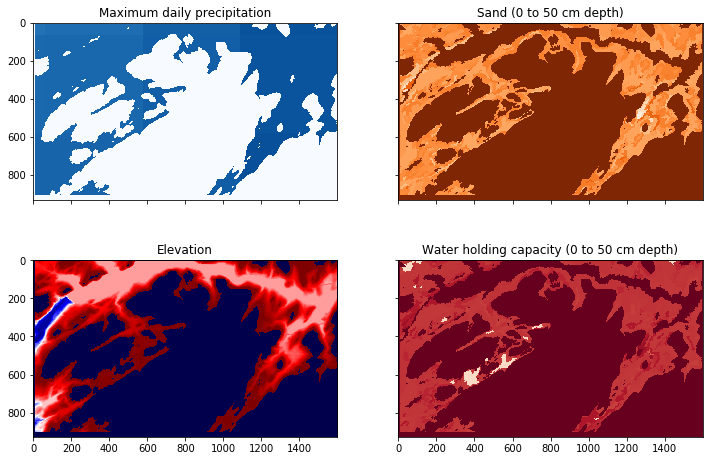

In [42]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

query_json = {
      "layers" : [
          {
            "type" : "raster", 
            "id" : "140", 
            "temporal" : {"intervals" : [{"start" : "2013-01-01T00:00:00Z", "end" : "2013-01-01T00:00:00Z"}]}, 
            "aggregation" : "Max", 
            "filter": {"operator": "LT", "value": "110"}
          },
          {"type" : "raster", "id" : "91", "aggregation" : "Sum"},
          {"type" : "raster", "id" : "91", "aggregation" : "Max"},
          {"type" : "raster", "id" : "48689", 
           "temporal" : {"intervals" : [{"snapshot" : "2015-01-01T00:00:00Z"}]}
          },
          {"type" : "raster", "id" : "48690", 
           "temporal" : {"intervals" : [{"snapshot" : "2015-01-01T00:00:00Z"}]}
          },
          {"type" : "raster", "id" : "48623", 
           "temporal" : {"intervals" : [{"snapshot" : "2015-01-01T00:00:00Z"}]}
          },
          {"type" : "raster", "id" : "48693", 
           "temporal" : {"intervals" : [{"snapshot" : "2015-01-01T00:00:00Z"}]}
          },
          {"type" : "raster", "id" : "48621", 
           "temporal" : {"intervals" : [{"snapshot" : "2015-01-01T00:00:00Z"}]}
          },
          {"type" : "raster", "id" : "48694", 
           "temporal" : {"intervals" : [{"snapshot" : "2015-01-01T00:00:00Z"}]}
          },
      ],
      "spatial" : {"type" : "square",  
                   "coordinates" : ["41.182206", "-73.867939", "41.239582", "-73.766468"]},
      "temporal" : {"intervals" : [{"start" : "2017-01-01T00:00:00Z", "end" : "2017-12-31T00:00:00Z"}]},
  }

# Submit the query
query_result = query.submit_check_status_and_download(query_json)

# Find layer files to load from downloaded zip.
files = query_result.list_files()
i = 0
for file in files : 
    print(str(i) + " " +  os.path.basename(file))
    i = i + 1

maxprecip = np.array(PIL.Image.open(files[2]))
sand = np.array(PIL.Image.open(files[10]))
elevation = np.array(PIL.Image.open(files[0]))
waterholding = np.array(PIL.Image.open(files[14]))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, True, True, figsize = (12, 8))
ax1.imshow(maxprecip, cmap = 'Blues', vmin = 0, vmax = 100)
ax1.set_title('Maximum daily precipitation')
ax2.imshow(sand, cmap = 'Oranges_r', vmin = 0, vmax = 1)
ax2.set_title('Sand (0 to 50 cm depth)')
ax3.imshow(elevation, cmap = 'seismic', vmin = 0, vmax = 100)
ax3.set_title('Elevation')
ax4.imshow(waterholding, cmap = 'RdBu', vmin = 0, vmax = 50)
ax4.set_title('Water holding capacity (0 to 50 cm depth)')
plt.show()

## Spatial aggregation

The result of a raster query can be aggregated spatially by modifying the ``"spatial"`` section of a query accordingly. Note that this feature requires the the query to be performed over a polygon. In other words, the value of the ``"type"`` field has to be ``"poly"``. For concreteness, let us consider the following example:


In [44]:
import pandas as pd

query_json =  {
    "layers": [
        {
            "alias" : "PRISM",
            "id": '92',
            "output": True,
            "aggregation" : "Max",
            "type": "raster"
        }
    ],
    "spatial" : {
        "type" : "poly", "aoi" : "125",
        "aggregation": {
            "aoi": ["125"]
        }
    },
    "temporal": {"intervals": [{"start" : "2019-01-01T00:00:00Z", "end" : "2020-01-01T00:00:00Z"}]},
  }

# Submit the query
query_result = query.submit_check_status_and_download(query_json)

# Find layer files to load from downloaded zip.
files = query_result.list_files()
print("Downloaded file = '" + os.path.basename(files[0]) + "'")

aggregation_df = pd.read_csv(files[0])
aggregation_df

2021-12-06 17:20:09 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2021-12-06 17:20:10 - paw - INFO - The query was successfully submitted with the id: 1638810000_01209886.
2021-12-06 17:20:10 - paw - INFO - The query 1638810000_01209886 has the status Queued.
2021-12-06 17:20:41 - paw - INFO - The query 1638810000_01209886 has the status Initializing.
2021-12-06 17:21:11 - paw - INFO - The query 1638810000_01209886 has the status Running.
2021-12-06 17:21:42 - paw - INFO - The query 1638810000_01209886 has the status Running.
2021-12-06 17:22:12 - paw - INFO - The query 1638810000_01209886 has the status Writing.
2021-12-06 17:22:42 - paw - INFO - The query 1638810000_01209886 has the status Succeeded.
2021-12-06 17:22:42 - paw - INFO - The query 1638810000_01209886 was successful after checking the status.
2021-12-06 17:23:13 - paw - INFO - The query 1638810000_01209886 has the status Succeeded.
2021-12-06 17:23:13 - paw - INFO - The query 1638810000_01209886 was suc

,PAIRS polygon ID,count()[unit: km^2],min(),max(),mean(),2nd moment
0,125,426983.337884,273.149994,324.241364,310.59714,96496.58619


The only novelty here is the appearance of ``"aggregation"`` in the ``"spatial"`` descriptor of the query. The value of ``"aggregation"`` is a list of polygon IDs, over which the query should aggregate. Note that these have to be subsets of the polygon defined by ``"aoi" : "125"`` over which the query is performed. In the above case, we are querying over California (125) and subsequently aggregating over it. If we used instead

```
  "spatial" : {
      "type" : "poly", "aoi" : "24",
      "aggregation": {
          "aoi": [str(poly) for poly in range(121, 172)]
      }
  }
```

we would be querying the conterminous USA (24) and aggregating over states (and Washington D.C.). Since we only queried over the conterminous USA however -- and PRISM data is only available for that area -- we are not getting any data for Alaska and Hawaii, polygons 122 and 132 respectively.

Spatial aggregation always returns the area (in Km**2) as well as the minimum, maximum, mean and 2nd moment. Returning to the above example, Geospatial Analytics returns a .csv file with the content that is printed above.